<a href="https://colab.research.google.com/github/hiydavid/time-series/blob/ts-xgboost-fixed/ts_forecasting_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with XGBoost

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
# load data
filepath = "https://raw.githubusercontent.com/hiydavid/time-series/main/data/PJME_hourly.csv"
pjme = pd.read_csv(filepath, index_col=[0], parse_dates=[0])
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


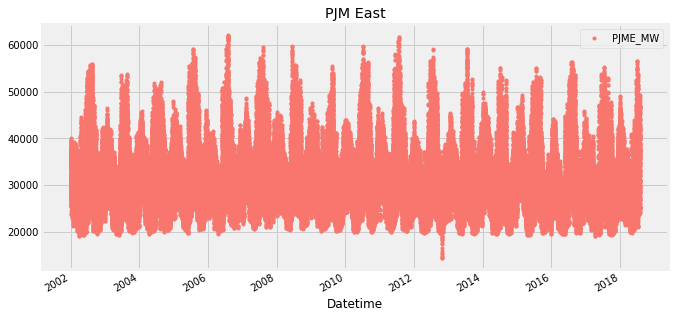

In [3]:
# visualize time series
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(10,5), color=color_pal[0], title='PJM East')

In [4]:
# create train vs test sets
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

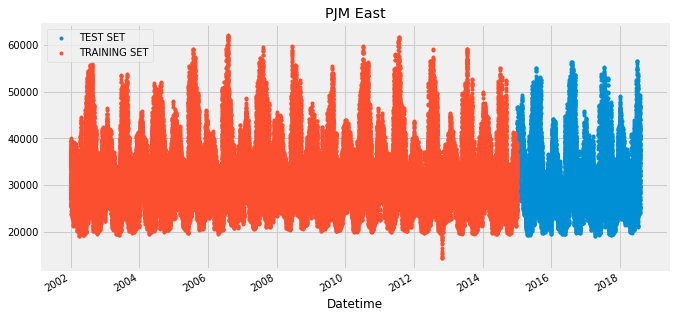

In [5]:
# visualize train vs test sets
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10,5), title='PJM East', style='.')

In [10]:
# function to extract features
def create_features(df, label=None):

    # day feature
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    # lags & rolling featyres
    df['pjme_6_hrs_lag'] = df['PJME_MW'].shift(6)
    df['pjme_12_hrs_lag'] = df['PJME_MW'].shift(12)
    df['pjme_24_hrs_lag'] = df['PJME_MW'].shift(24)
    df['pjme_6_hrs_mean'] = df['PJME_MW'].rolling(window = 6).mean()
    df['pjme_12_hrs_mean'] = df['PJME_MW'].rolling(window = 12).mean()
    df['pjme_24_hrs_mean'] = df['PJME_MW'].rolling(window = 24).mean()
    df['pjme_6_hrs_std'] = df['PJME_MW'].rolling(window = 6).std()
    df['pjme_12_hrs_std'] = df['PJME_MW'].rolling(window = 12).std()
    df['pjme_24_hrs_std'] = df['PJME_MW'].rolling(window = 24).std()
    df['pjme_6_hrs_max'] = df['PJME_MW'].rolling(window = 6).max()
    df['pjme_12_hrs_max'] = df['PJME_MW'].rolling(window = 12).max()
    df['pjme_24_hrs_max'] = df['PJME_MW'].rolling(window = 24).max()
    df['pjme_6_hrs_min'] = df['PJME_MW'].rolling(window = 6).min()
    df['pjme_12_hrs_min'] = df['PJME_MW'].rolling(window = 12).min()
    df['pjme_24_hrs_min'] = df['PJME_MW'].rolling(window = 24).min()
    
    # get data
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'dayofmonth','weekofyear', 'pjme_6_hrs_lag', 'pjme_24_hrs_lag', 
            'pjme_6_hrs_mean', 'pjme_12_hrs_mean', 'pjme_24_hrs_mean',
            'pjme_6_hrs_std', 'pjme_12_hrs_std', 'pjme_24_hrs_std',
            'pjme_6_hrs_max', 'pjme_12_hrs_max', 'pjme_24_hrs_max',
            'pjme_6_hrs_min', 'pjme_12_hrs_min', 'pjme_24_hrs_min']]

    # if label is called
    if label:
        y = df[label]
        return X, y

    return X

In [11]:
# create train vs test sets
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [12]:
# train model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False
)

[05:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

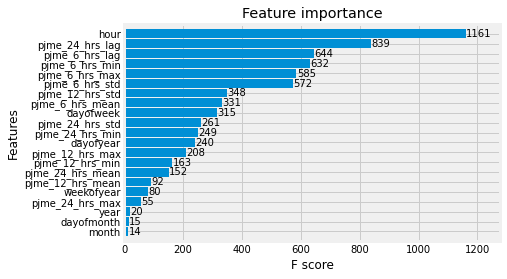

In [15]:
# view feature importance
_ = plot_importance(reg, height=0.9)

In [16]:
# make predictions
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

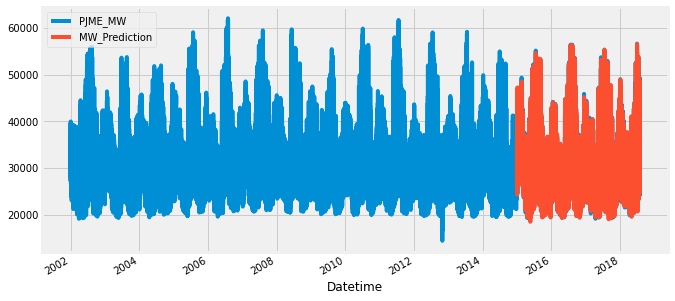

In [17]:
# visualize predictions
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(10, 5))

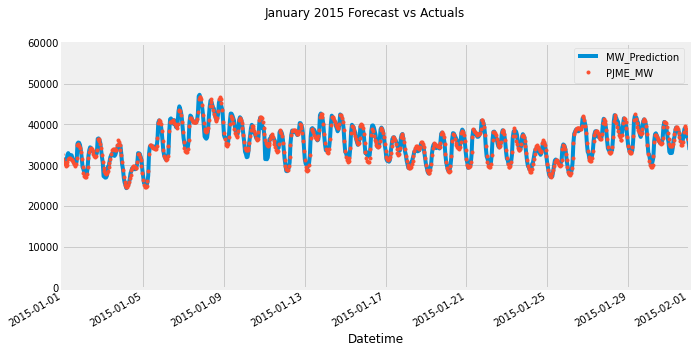

In [18]:
# visualize prediction vs. actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

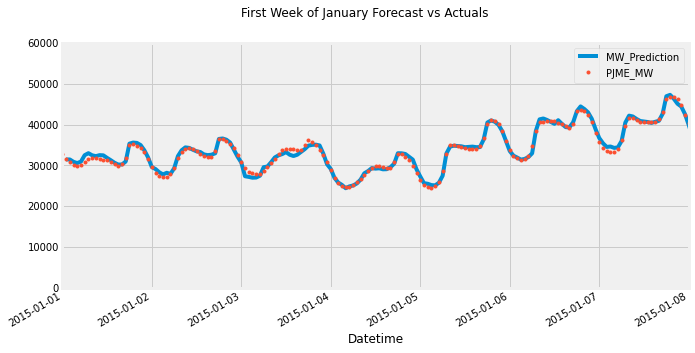

In [19]:
# visualize prediction vs. actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

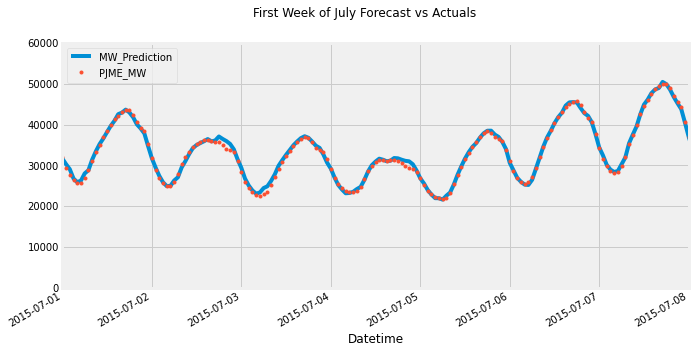

In [20]:
# visualize prediction vs. actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [21]:
# calculate mse
mean_squared_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test['MW_Prediction']
)

426144.6905834089

In [22]:
# calculate mae
mean_absolute_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test['MW_Prediction']
)

421.7252040906597

In [23]:
# function to calculate mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
# calculate mape
mean_absolute_percentage_error(
    y_true=pjme_test['PJME_MW'],
    y_pred=pjme_test['MW_Prediction']
)

1.357268021419272

In [25]:
# create error table
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[
    ['PJME_MW','MW_Prediction','error','abs_error']
]

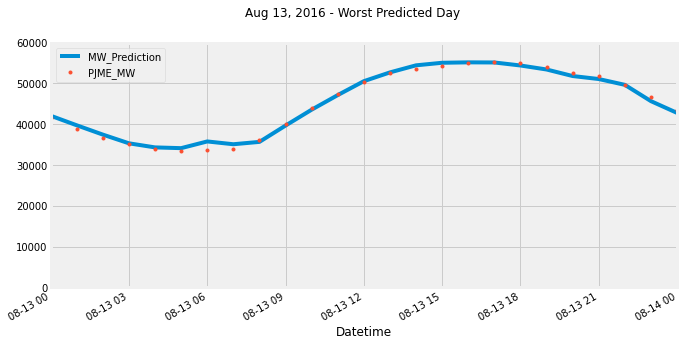

In [26]:
# visualize worst prediction 
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

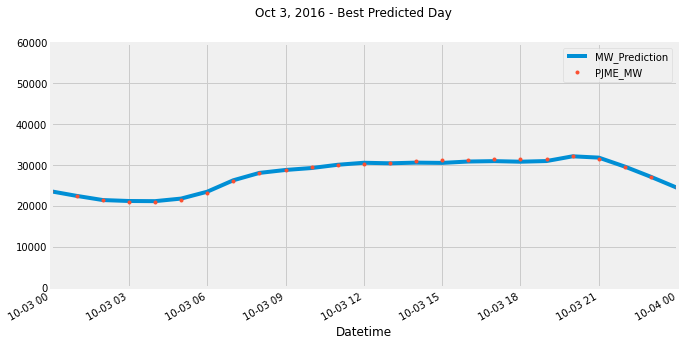

In [27]:
# visualize best prediction
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')